<table>
    <tr>
        <td>
            <img src="https://www.arm.gov/uploads/53943128233_e595b5afeb_c.jpg" style="height: 200px;" alt="BNF Campaign"></img>
        </td>
        <td>
            <h1>Atmospheric Radiation Measurement user facility (ARM)</h1>
            <h1>Bankhead National Forest (BNF)</h1>
            Notebook for learning the basics of ACT with BNF data </br>
            Corresponding Author: Adam Theisen (atheisen@anl.gov)
        </td>
    </tr>
</table>

## Overview
The third ARM Mobile Facility (AMF3) has deployed to Bankhead National Forest in northern Alabama, opening October 1, 2024.  For at least five years, the BNF will investigate the complex interactions among clouds, vegetation, and aerosols suspended in the atmosphere.  This will be done using the instrumentation at the main site, 43-meter tower site, and three supplemental sites in the region.  This tutorial will provide an introduction to ACT using the BNF data.

1. Intro to ACT
1. Instrument Overview
1. Downloading and Reading in MET Data
1. Quality Controlling Data
1. Visualizing Data
1. Questions for the User to Explore

## Prerequisites
This notebook will rely heavily on Python and the [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT).  Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webservice information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |

- **Time to learn**: 15 Minutes
- **System requirements**:
    - Python 3.11 or latest
    - ACT v2.0.0 or latest
    - numpy
    - xarray
    - matplotlib

---

## Intro to ACT
           
The [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT) is an open-source Python toolkit for exploring and analyzing atmospheric time-series datasets.  Examples can be found in the [ACT Example Gallery](https://arm-doe.github.io/ACT/source/auto_examples/index.html).  The toolkit has modules for many different parts of the scientific process, including:

<table>
    <tr>
        <td>
            
#### Data Discovery (act.discovery)
The [discovery](https://arm-doe.github.io/ACT/API/generated/act.discovery.html) module houses functions to download or access data from different groups.  Currently it includes function to get data for ARM, NOAA, EPA, NEON, and more!

#### Input/Output (act.io)
[io](https://arm-doe.github.io/ACT/API/generated/act.io.html) contains functions for reading and writing data from various sources and formats.

#### Visualization (act.plotting)
[plotting](https://arm-doe.github.io/ACT/API/generated/act.plotting.html) contains various routines, built on matplotlib, to help visualize and explore data.  These include 
1. Time-series plots
1. Distribution plots like histograms and heatmaps
1. Geographic plots for moving systems like radiosondes or aircraft
1. Skew-T plots for radiosonde data, built off MetPy
1. Wind rose plots for wind and data roses
1. Cross-section plots for working with 3-dimensional data

#### Corrections (act.corrections)
[corrections](https://arm-doe.github.io/ACT/API/generated/act.corrections.html) apply different corrections to data based on need.  A majority of the existing corrections are for lidar data.

#### Quality Control (act.qc)
The [qc](https://arm-doe.github.io/ACT/API/generated/act.qc.html) module has a lot of functions for working with quality control information, apply new tests, or filtering data based on existing tests.  We will explore some of that functionality in this notebook.

#### Retrievals (act.retrievals)
There are many cases in which some additional calculations are necessary to get more value from the instrument data.  The [retrievals](https://arm-doe.github.io/ACT/API/generated/act.retrievals.html) module houses some functions for performing these advanced calculations.  

#### Utilities (act.utils)
The [utils](https://arm-doe.github.io/ACT/API/generated/act.utils.html) module has a lot of general utilities to help with the data.  Some of these include adding in a solar variable to indicate day/night (useful in filtering data), unit conversions, decoding WMO weather codes, performing weighted averaging, etc...
        </td>
        <td>
            <center>
            <img src="https://arm-doe.github.io/ACT/_images/sphx_glr_plot_neon_001.png" alt="NEON-ARM"></img>
            <figcaption>ARM and NEON data from Utquivaik, AK</figcaption>
            <img src="https://arm-doe.github.io/ACT/_images/sphx_glr_plot_enhanced_skewt_001.png" alt="SONDE"></img>
            <figcaption>Enhanced Skew-T plot from ARM's Southern Great Plains Site (SGP)</figcaption>
            </center>
        </td>
    </tr>
</table>

---

## Instrument Overview
<table>
    <tr>
        <td>
            
### Surface Meteorological Instrumentation (MET)
The ARM Surface Meteorology Systems (MET) use mainly conventional in situ sensors to obtain 1-minute statistics of surface wind speed, wind direction, air temperature, relative humidity, barometric pressure, and rain-rate. [Learn more](https://arm.gov/capabilities/instruments/met)

### Scanning mobility particle sizer (SMPS)
The scanning mobility particle sizer (SMPS) is a particle size spectrometer that measures the aerosol number size distribution by sizing particles based on their electrical mobility diameter using a differential mobility analyzer (DMA) and by counting particles using a condensation particle counter (CPC). It measures aerosol concentration and aerosol particle size distribution. [Learn more](https://arm.gov/capabilities/instruments/smps)
        </td>
        <td>
            <center>
            <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSlalH8VdAICnQaOvlQ3tz_2QYu29F39S08SA&s" alt="MET"></img>
            <figcaption>Surface Meteorology Station</figcaption>
            </center>
        </td>
    </tr>
</table>

---

## Imports
Let's get started with some data!  But first, we need to import some libraries.

In [1]:
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Downloading and Reading ARM's NetCDF Data
ARM's standard file format is NetCDF (network Common Data Form) which makes it very easy to work with in Python!  ARM data are available through a data portal called [Data Discovery](https://adc.arm.gov/discovery/#/) or through a webservice.  If you didn't get your username and token earlier, please go back and see the Prerequisites!

Let's download some of the MET data first!

In [2]:
# Set your username and token here!
username = 'theisen'
token = '500ad19936dd73a0'

# Set the datastream and start/enddates
datastream = 'bnfmetM1.b1'
startdate = '2024-12-16'
enddate = '2024-12-19T23:59:59'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result_met = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

datastream = 'bnfaossmpsM1.b1'
result_smps = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

https://adc.arm.gov/armlive/livedata/query?user=theisen:500ad19936dd73a0&ds=bnfmetM1.b1&start=2024-12-16T00:00:00.000Z&end=2024-12-19T23:59:59.000Z&wt=json
[DOWNLOADING] bnfmetM1.b1.20241219.000000.cdf
[DOWNLOADING] bnfmetM1.b1.20241217.000000.cdf
[DOWNLOADING] bnfmetM1.b1.20241216.000000.cdf
[DOWNLOADING] bnfmetM1.b1.20241218.000000.cdf

If you use these data to prepare a publication, please cite:

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2024-12-16 to 2024-12-19, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) (M1).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

https://adc.arm.gov/armlive/livedata/query?user=theisen:500ad19936dd73a0&ds=bnfaossmpsM1.b1&start=2024-12-16T00:00:00.000Z&end=2024-12-19T23:59:59.000Z&wt=json
[DOWNLOADING] bnfaossmpsM1.b1.20241217.000000.nc
[DOWNLOADING] bnfaossmpsM1.b1.20241219.000001.nc
[DOWNLOADING] bnfaoss

### Note: Did you notice the citation and DOI?

In [4]:
# Let's read in the data using ACT and check out the data
ds_met = act.io.read_arm_netcdf(result_met)
ds_smps = act.io.read_arm_netcdf(result_smps)

ds_met

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 5760, bound: 2)
Coordinates:
  * time                          (time) datetime64[ns] 46kB 2024-12-16 ... 2...
Dimensions without coordinates: bound
Data variables: (12/51)
    base_time                     (time) datetime64[ns] 46kB 2024-12-16 ... 2...
    time_offset                   (time) datetime64[ns] 46kB 2024-12-16 ... 2...
    time_bounds                   (time, bound) object 92kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    atmos_pressure                (time) float32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure             (time) int32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean                     (time) float32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) int32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    logger_temp                   (time) float32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_logger_temp                (time) int32 23kB dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                           (time) float32 23kB 34.34 34.34 ... 34.34
    lon                           (time) float32 23kB -87.34 -87.34 ... -87.34
    alt                           (time) float32 23kB 293.0 293.0 ... 293.0
Attributes: (12/26)
    command_line:                met_ingest -s bnf -f M1
    Conventions:                 ARM-1.3
    process_version:             ingest-met-4.56-0.el7
    dod_version:                 met-b1-7.6
    input_source:                /data/collection/bnf/bnfmetM1.00/M1_MET_Tabl...
    site_id:                     bnf
    ...                          ...
    tbrg_precip_corr_info:       0.001000 * tbrg_precip_total^2 + 0.883000 * ...
    history:                     created by user dsmgr on machine prod-proc2....
    _file_dates:                 ['20241216', '20241217', '20241218', '202412...
    _file_times:                 ['000000', '000000', '000000', '000000']
    _datastream:                 bnfmetM1.b1
    _arm_standards_flag:         1

## Quality Controlling Data

ARM has multiple methods that it uses to communicate data quality information out to the users.  One of these methods is through "embedded QC" variables.  These are variables within the file that have information on automated tests that have been applied.  Many times, they include Min, Max, and Delta tests but as is the case with the AOS instruments, there can be more complicated tests that are applied.

The results from all these different tests are stored in a single variable using bit-packed QC.  We won't get into the full details here, but it's a way to communicate the results of multiple tests in a single integer value by utilizing binary and bits!  You can learn more about bit-packed QC [here](https://code.arm.gov/docs/QC-flag-examples/-/wikis/home) but ACT also has many of the tools for working with ARM QC.

#### Other Sources of Quality Control
ARM also communicates problems with the data quality through Data Quality Reports (DQR).  These reports are normally submitted by the instrument mentor when there's been a problem with the instrument.  The categories include:

- **Data Quality Report Categories**
    - Missing: Data are not available or set to -9999
    - Suspect: The data are not fully incorrect but there are problems that increases the uncertainty of the values. Data should be used with caution.
    - Bad: The data are incorrect and should not be used.
    - Note: Data notes are a way to communicate information that would be useful to the end user but does not rise to the level of suspect or bad data
    
Additionally, data quality information can be found in the Instrument Handbooks, which are included on most instrument pages.  Here is an [example](https://www.arm.gov/publications/tech_reports/handbooks/met_handbook.pdf) of the MET handbook.

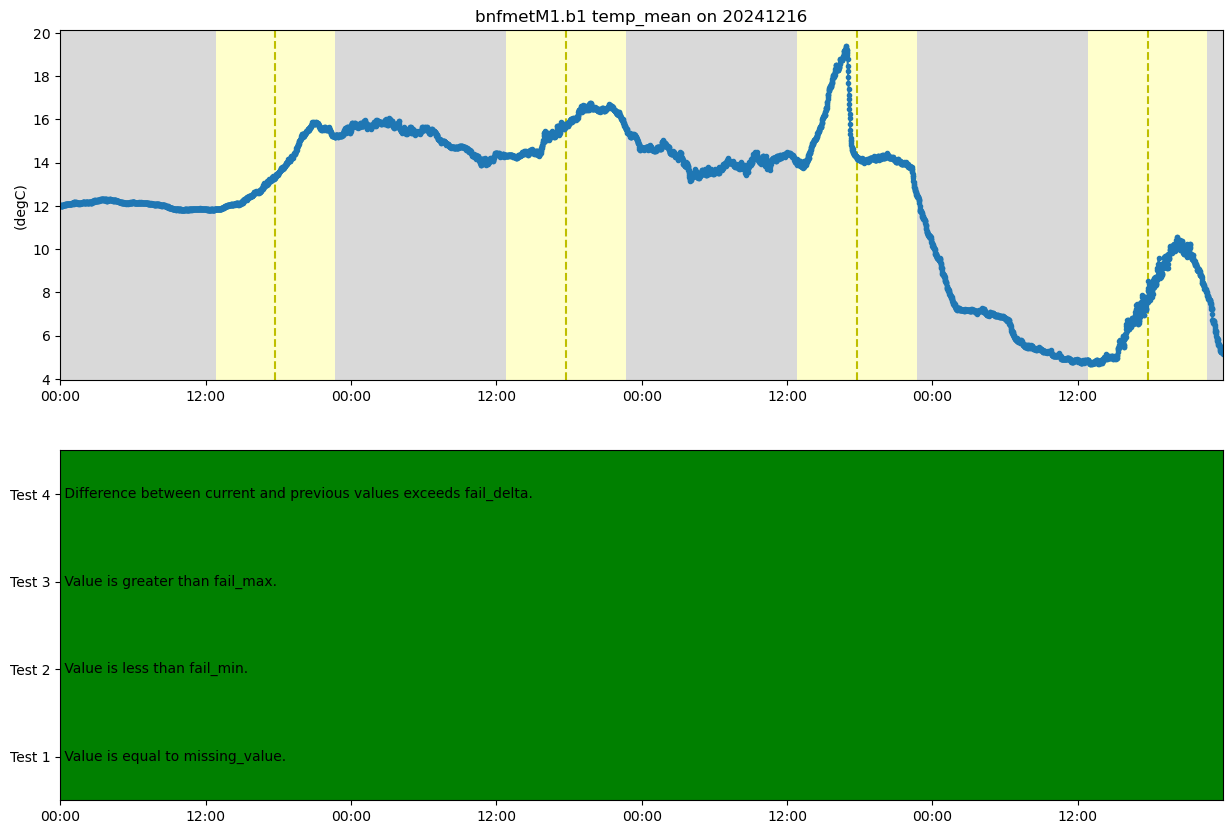

In [5]:
# We can see that there's some missing data in the plot above so let's take a look at the embedded QC!
# First, for many of the ACT QC features, we need to get the dataset more to CF standard and that
# involves cleaning up some of the attributes and ways that ARM has historically handled QC
ds_met.clean.cleanup()

# Next, let's take a look at visualizing the quality control information
# Create a plotting display object with 2 plots
variable = 'temp_mean'
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(15, 10), subplot_shape=(2,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()

#### ARM Data Quality Reports (DQR)!
ARM's DQRs can be easily pulled in and added to the QC variables using ACT.  We can do that with the below one line command.  However, for this case, there won't be any DQRs on the data but let's visualize it just in case!

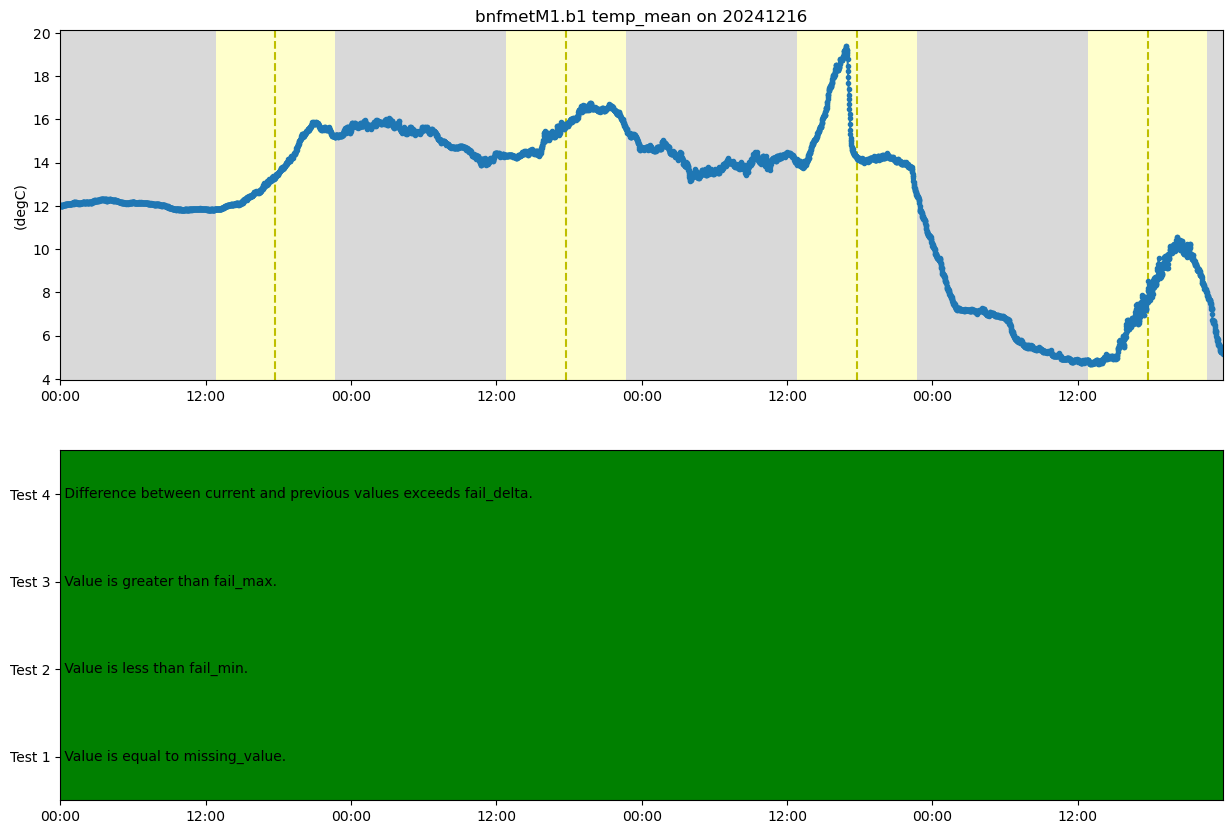

In [6]:
# Query the ARM DQR Webservice
ds_met = act.qc.add_dqr_to_qc(ds_met, variable=variable)

#And plot again!
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(15, 10), subplot_shape=(2,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()

## Visualizing Data
We've already worked with visualizing the data in basic ways but what other options are there in ACT?  This section will show you how to create a variety of different plots.  More plotting examples can be found in [ACT's Documentation](https://arm-doe.github.io/ACT/source/auto_examples/index.html#plotting-examples).

### Multi-Panel Plot
This example shows how to plot the MET and SMPS together on a multi-panel plot.

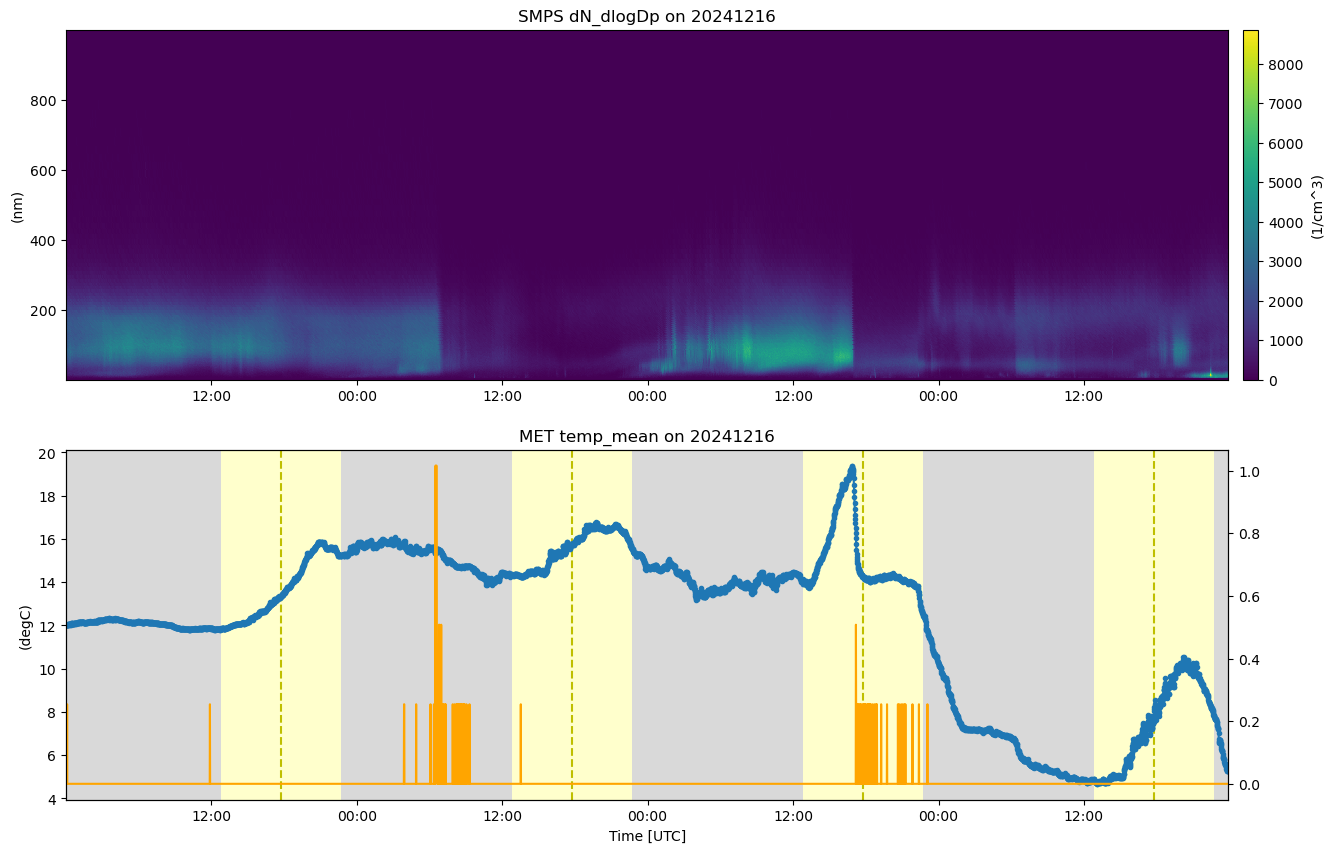

In [7]:
#And plot again!
# Create a plotting display object with 2 plots
# Note we have to create a dictionary of datasets to pass in
display = act.plotting.TimeSeriesDisplay({'SMPS': ds_smps, 'MET': ds_met}, figsize=(15, 10), subplot_shape=(2,))

# Plot up the variable in the first plot
# Need to specify the dsname so it knows which dataset
# to use for this data.  This is helpful when datasets 
# have similar variable names
display.plot('dN_dlogDp', dsname='SMPS', subplot_index=(0,))

# Plot up the MET btemperature and precipitation
display.plot('temp_mean', dsname='MET', subplot_index=(1,))
ax2 = display.axes[1].twinx()
ax2.plot(ds_met.time, ds_met.tbrg_precip_total, color='orange')

# Plot up a day/night background
display.day_night_background(dsname='MET', subplot_index=(1,))

### Adding some customization
Let's make this plot a little nicer and easier to read.  We can use a mix of ACT and Matplotlib to help

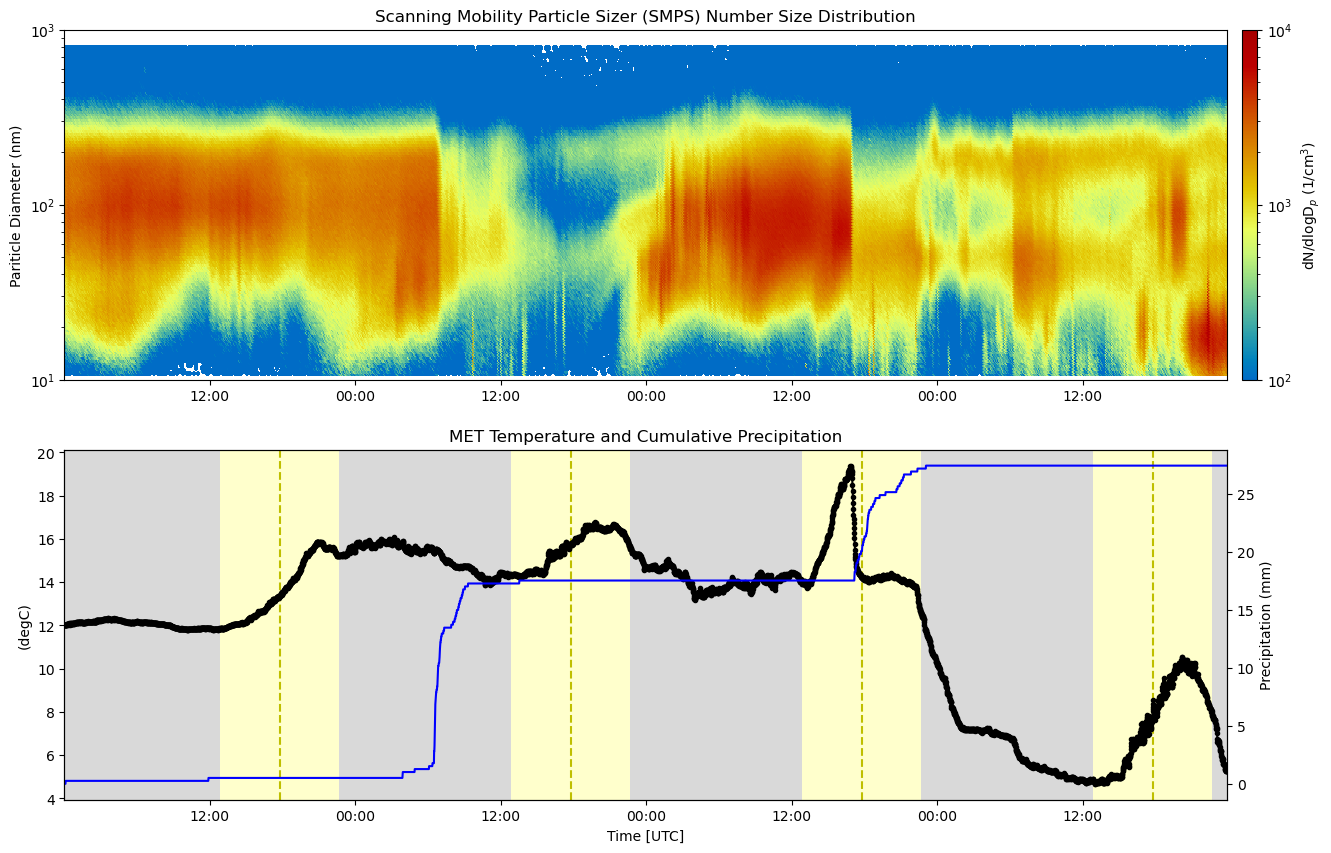

In [8]:
#And plot again!
# Create a plotting display object with 2 plots
# Note we have to create a dictionary of datasets to pass in
display = act.plotting.TimeSeriesDisplay({'SMPS': ds_smps, 'MET': ds_met}, figsize=(15, 10), subplot_shape=(2,))

# Let's add in titles and more to the SMPS plot
title = 'Scanning Mobility Particle Sizer (SMPS) Number Size Distribution'
cbar_title = 'dN/dlogD$_p$ (1/cm$^{3}$)'
display.plot('dN_dlogDp', dsname='SMPS', subplot_index=(0,), cvd_friendly=True,
             norm=colors.LogNorm(vmin=100., vmax=10000.), set_title=title, cbar_label=cbar_title,
             ylabel='Pariticle Diameter (nm)')
display.axes[0].set_yscale('log')
display.set_yrng([10, 1000], subplot_index=(0,))

# Let's accumulate the precipitation using ACT to make this easier to read
ds_met = act.utils.data_utils.accumulate_precip(ds_met, 'tbrg_precip_total')

# Plot up the MET btemperature and precipitation
title = 'MET Temperature and Cumulative Precipitation'
display.plot('temp_mean', dsname='MET', subplot_index=(1,), set_title=title, color='black')
ax2 = display.axes[1].twinx()
ax2.plot(ds_met.time, ds_met.tbrg_precip_total_accumulated, color='blue')
ax2.set_ylabel('Precipitation (mm)')

# Plot up a day/night background
display.day_night_background(dsname='MET', subplot_index=(1,))

### Distribution Display

For the example, we will go over some functions within ACT's distribution display. Functions such as, the stacked bar plot, scatter and groupby.

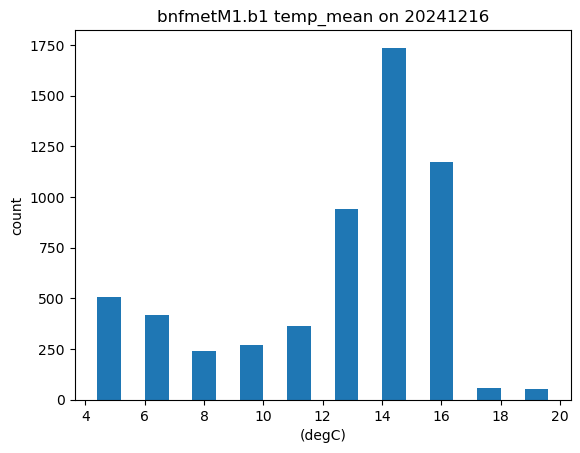

In [9]:
# First, let's plot up a histogram of the data
# All the ACT plotting is very similar to what we
# did earlier, first we create a display object
display = act.plotting.DistributionDisplay(ds_met)

# And then we can plot the data!  Note that we are passing a range into the
# histogram function to set the min/max range of the data
display.plot_stacked_bar('temp_mean', hist_kwargs={'range': [4, 20]})
plt.show()

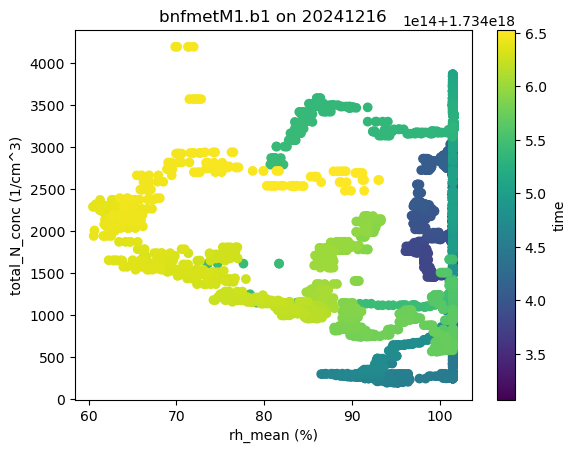

In [10]:
# First we need to combine data and to do that, we need to get it on the same time grid
ds_combined = xr.merge([ds_met.resample(time='1min').nearest(), ds_smps.resample(time='1min').nearest()], compat='override')


# Next up, let's do some scatter plots to compare some variables
# Scatter plots are also found in the DistributionDisplay module
display = act.plotting.DistributionDisplay(ds_combined)

# And then we can plot the data!
display.plot_scatter('rh_mean', 'total_N_conc', m_field='time')

plt.show()

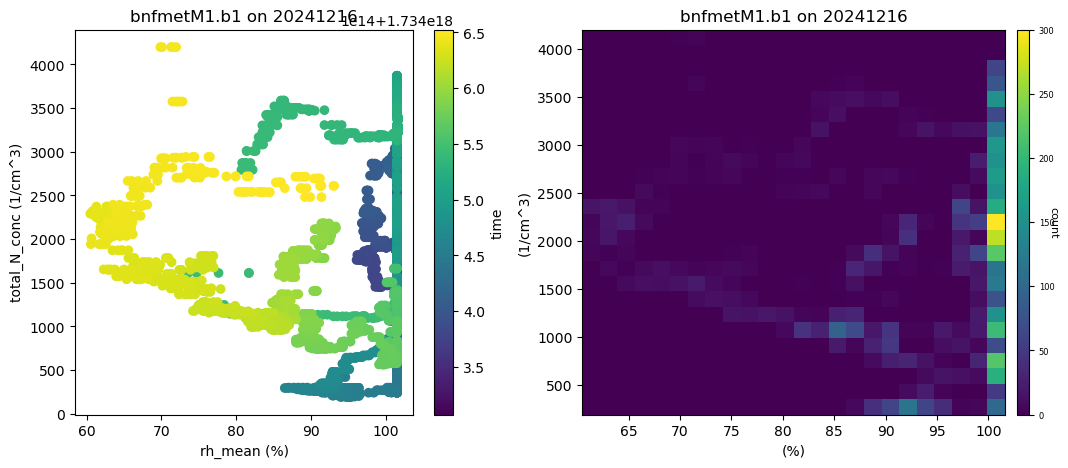

In [11]:
# Sometimes these scatter plots hide the number of points there actually
# are in some areas so let's try a heatmap as well
display = act.plotting.DistributionDisplay(ds_combined, figsize=(12, 5), subplot_shape=(1, 2))

# And then we can plot the data!
display.plot_scatter('rh_mean', 'total_N_conc', m_field='time', subplot_index=(0, 0))
# This can be used to adjust the axes limits
# display.set_xrng([0, 20], subplot_index=(0, 0))

# we can also pass in an array of values for the bins using np.arange(start, stop, step)
display.plot_heatmap('rh_mean', 'total_N_conc', subplot_index=(0, 1), x_bins=25, y_bins=25)
plt.show()

### Data Rose Plots

If your data may be wind speed or direction dependent, these plots can help inform where the influences may be coming from.  For this example, let's see if the total number concentration from the SMPS is dependent on wind direction.

/Users/atheisen/Code/ACT/act/plotting/windrosedisplay.py:358: RuntimeWarning: Mean of empty slice
  arr.append(np.nanmean(data[idx]))


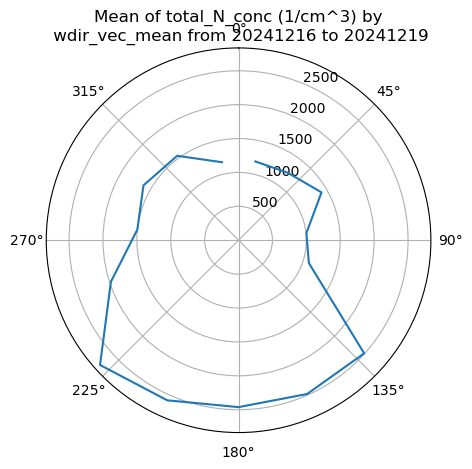

In [12]:
# Plot out the data rose using the WindRose display object
display = act.plotting.WindRoseDisplay(ds_combined)
display.plot_data('wdir_vec_mean', 'wspd_vec_mean', 'total_N_conc', num_dirs=15, plot_type='line', line_plot_calc='mean')
plt.show()

/Users/atheisen/Code/ACT/act/plotting/windrosedisplay.py:429: RuntimeWarning: Mean of empty slice
  mean_data[i, j] = np.nanmean(data[idx])


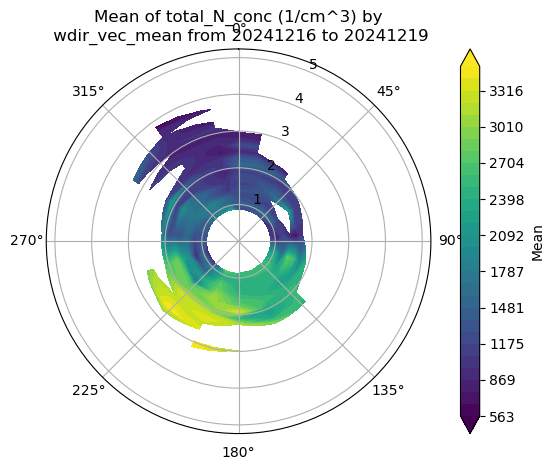

In [13]:
# Plot out the data rose using the WindRose display object
display = act.plotting.WindRoseDisplay(ds_combined)

# Let's try a different type of data rose type that is using contours amd the polar y axis is wind speed
# depending on wind direction and speed
display.plot_data('wdir_vec_mean', 'wspd_vec_mean', 'total_N_conc', num_dirs=15, plot_type='contour', contour_type='mean')
plt.show()

---

### Data Used in this Notebook
Kuang, C., Singh, A., Howie, J., Salwen, C., & Hayes, C. Scanning mobility particle sizer (AOSSMPS), 2024-12-16 to 2024-12-19, Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) (M1). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1476898

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation (MET), 2024-12-16 to 2024-12-19, Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) (M1). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1786358